In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

In [3]:
import pickle as pkl

def save(filename, obj):
    with open(filename, 'wb') as f:
        pkl.dump(obj, f)

def load(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

In [4]:
# Addition of MPS with open boundary condition

def dsum(A, B):

    d = A.shape[1]
    assert d == B.shape[1]

    dsum = np.zeros((A.shape[0] + B.shape[0], d, A.shape[2] + B.shape[2]))
    dsum[:A.shape[0], :, :A.shape[2]] = A
    dsum[A.shape[0]:, :, A.shape[2]:] = B

    return dsum


def row(A, B):

    assert A.shape[0] == B.shape[0] == 1
    d = A.shape[1]
    assert d == B.shape[1]

    row = np.zeros((1, d, A.shape[2] + B.shape[2]))
    row[:, :, :A.shape[2]] = A
    row[:, :, A.shape[2]:] = B

    return row


def col(A, B):

    assert A.shape[2] == B.shape[2] == 1
    d = A.shape[1]
    assert d == B.shape[1]

    col = np.zeros((A.shape[0] + B.shape[0], d, 1))
    col[:A.shape[0], :, :] = A
    col[A.shape[0]:, :, :] = B

    return col


def add(mps_a, mps_b):

    L = len(mps_a)
    assert len(mps_b) == L

    mps = [row(mps_a[0], mps_b[0])] + [dsum(mps_a[i], mps_b[i]) for i in range(1, L - 1)] + [col(mps_a[L - 1], mps_b[L - 1])]

    return mps


def compress(mps, χ_max, normalize=False):

    L = len(mps)
    norm = np.array([[[1]]])
    mps = mps + [norm]
    for n in range(L):

        # SVD truncation
        vL, d, vR = mps[n].shape
        M = mps[n].reshape(vL*d, vR)
        U, S, Vh = sp.linalg.svd(M, full_matrices=False, lapack_driver='gesvd')
#        try:
#            U, S, Vh = np.linalg.svd(M, full_matrices=False)
#        except np.linalg.LinAlgError:
#            U, S, Vh = sp.linalg.svd(M, full_matrices=False, lapack_driver='gesvd')
        U, S, Vh = U[:, :χ_max], S[:χ_max], Vh[:χ_max, :]
        χ = len(S)
        mps[n] = U.reshape(vL, d, χ)

        # absorb SVD tensors into next tensor
        vL, d, vR = mps[n+1].shape
        M = mps[n+1].reshape(vL, d*vR)
        mps[n+1] = ((S[:, None] * Vh) @ M).reshape(χ, d, vR)

    if mps[-1].item().real < 0:
        mps[-1] *= -1
        mps[-2] *= -1
    norm = mps[-1].item().real
    del mps[-1]

    if not normalize: # re-normalize to original norm
        mps = [M * norm**(1/L) for M in mps]

    return mps, norm

In [5]:
# MPS model functions

def mean_filter(x):
    return x.reshape(14, 2, 14, 2).transpose(0, 2, 1, 3).mean(axis=(2, 3))


def image_to_mps(x):

    mps = list()
    for pixel in x.flatten():

        M = np.zeros([1, 2, 1], float)
        M[0, 0, 0] = np.cos(np.pi/2*pixel/255)
        M[0, 1, 0] = np.sin(np.pi/2*pixel/255)
        mps.append(M)

    return mps


def inner_product(mps_a: list, mps_b: list):

    L = len(mps_a)
    assert L == len(mps_b)

    t = np.tensordot(mps_b[0], mps_a[0].conj(), axes=[1, 1])
    t = t.squeeze(axis=(0, 2))
    for n in range(1, L):

        t = np.tensordot(t, mps_b[n], axes=[0, 0])
        t = np.tensordot(t, mps_a[n].conj(), axes=[[0, 1], [0, 1]])

    return t.item()


def train(X, Y, χ_max):

    model = list()
    for digit in range(10):

        samples = X[Y == digit]
        for n, x in enumerate(samples):

            x = image_to_mps(mean_filter(x))
            Ψ = add(Ψ, x) if n > 0 else x

            if n + 1 == len(samples):
                Ψ, _ = compress(Ψ, χ_max, normalize=True)

            elif (n + 1)%χ_max == 0 and n + 1 >= 2*χ_max:
                Ψ, _ = compress(Ψ, χ_max, normalize=False)

        model.append(Ψ)

    return model


def project(model, x):
    return [abs(inner_product(ψ, image_to_mps(mean_filter(x)))) for ψ in model]


def predict(model, x):

    projections = project(model, x)
    prediction = np.argmax(projections)

    return prediction


def compute_accuracies(model, X, Y):

    accuracies = list()
    for digit in range(10):

        samples = X[Y==digit]
        projections = [project(model, x) for x in samples]
        predictions = np.argmax(projections, axis=1)
        accuracy = sum(predictions == digit) / len(samples)
        accuracies.append(accuracy)

    return accuracies

In [6]:
def load_data(fname):
    data = np.loadtxt(fname, delimiter=',')
    X, Y = data[:, 1:].reshape(-1, 28, 28), data[:, 0]
    return X, Y

In [7]:
X, Y = load_data('data/mnist_train.csv')
X_test, Y_test = load_data('data/mnist_test.csv')

In [ ]:
χ_list = [10, 20, 30, 40, 50, 60]
for χ_max in χ_list:
    start = time.time()

    model = train(X, Y, χ_max)

    print('χ_max=%d'%χ_max, 'training time [min]: ', (time.time() - start)/60)

    save('results/chi%d_model.pkl'%(χ_max), model)

χ_max=10 training time [min]:  5.333066697915395
χ_max=20 training time [min]:  7.6969634334246315
χ_max=30 training time [min]:  11.139228244622549
χ_max=40 training time [min]:  24.281578063964844
χ_max=50 training time [min]:  45.598906183242796
χ_max=60 training time [min]:  58.36546700398127


In [ ]:
for χ_max in χ_list:
    model = load('results/chi%d_model.pkl'%(χ_max))

    start = time.time()

    accuracies = compute_accuracies(model, X_test, Y_test)

    print('χ_max=%d'%χ_max, 'evaluation time: ',(time.time() - start)/60)

    save('results/chi%d_accuracies.pkl'%(χ_max), accuracies)

χ_max=10 evaluation time:  13.845400627454122
χ_max=20 evaluation time:  14.129004502296448
χ_max=30 evaluation time:  13.695018212000528
χ_max=40 evaluation time:  13.727141980330149
χ_max=50 evaluation time:  14.333614695072175


In [ ]:
for χ_max in [60]:
    model = load('results/chi%d_model.pkl'%(χ_max))

    start = time.time()

    accuracies = compute_accuracies(model, X_test, Y_test)

    print('χ_max=%d'%χ_max, 'evaluation time: ',(time.time() - start)/60)

    save('results/chi%d_accuracies.pkl'%(χ_max), accuracies)

χ_max=60 evaluation time:  16.65675457715988


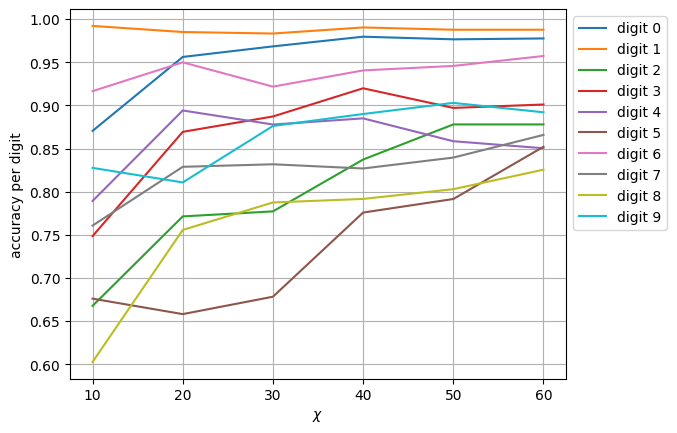

In [8]:
χ_list = [10, 20, 30, 40, 50, 60]
acc = np.zeros((10, len(χ_list)))
for i, chi in enumerate(χ_list):
    acc[:, i] = load('results/chi%d_accuracies.pkl'%(chi))


fig, ax = plt.subplots()
for digit in range(10):
    ax.plot(χ_list, acc[digit, :], label='digit %d'%(digit))
ax.set_xticks(χ_list), ax.set_xlabel('$\chi$'), ax.set_ylabel('accuracy per digit'), ax.grid(), ax.legend(bbox_to_anchor=(1.0, 1.0))
fig.savefig('results/accuracy.pdf')

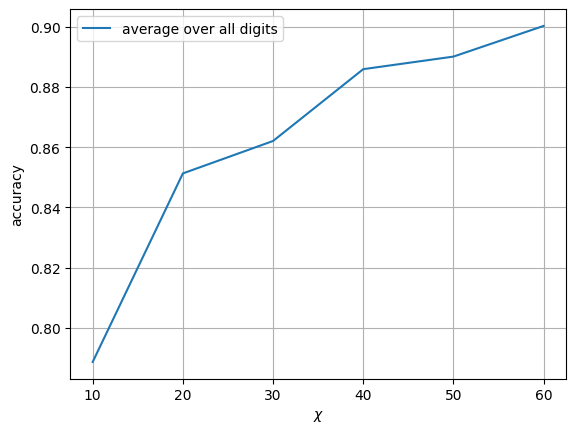

In [14]:
weights = np.array([(Y==digit).sum() for digit in range(10)]) / len(Y)
acc_total = (acc * weights.reshape(-1, 1)).sum(axis=0)


fig, ax = plt.subplots()
ax.plot(χ_list, acc_total, label='average over all digits')
ax.set_xticks(χ_list), ax.set_xlabel('$\chi$'), ax.set_ylabel('accuracy'), ax.grid(), ax.legend();
fig.savefig('results/total_accuracy.pdf')